## Resultado 1


/tmp/ipykernel_3463/3345946599.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Gráfico salvo: plots/resultado1.pdf


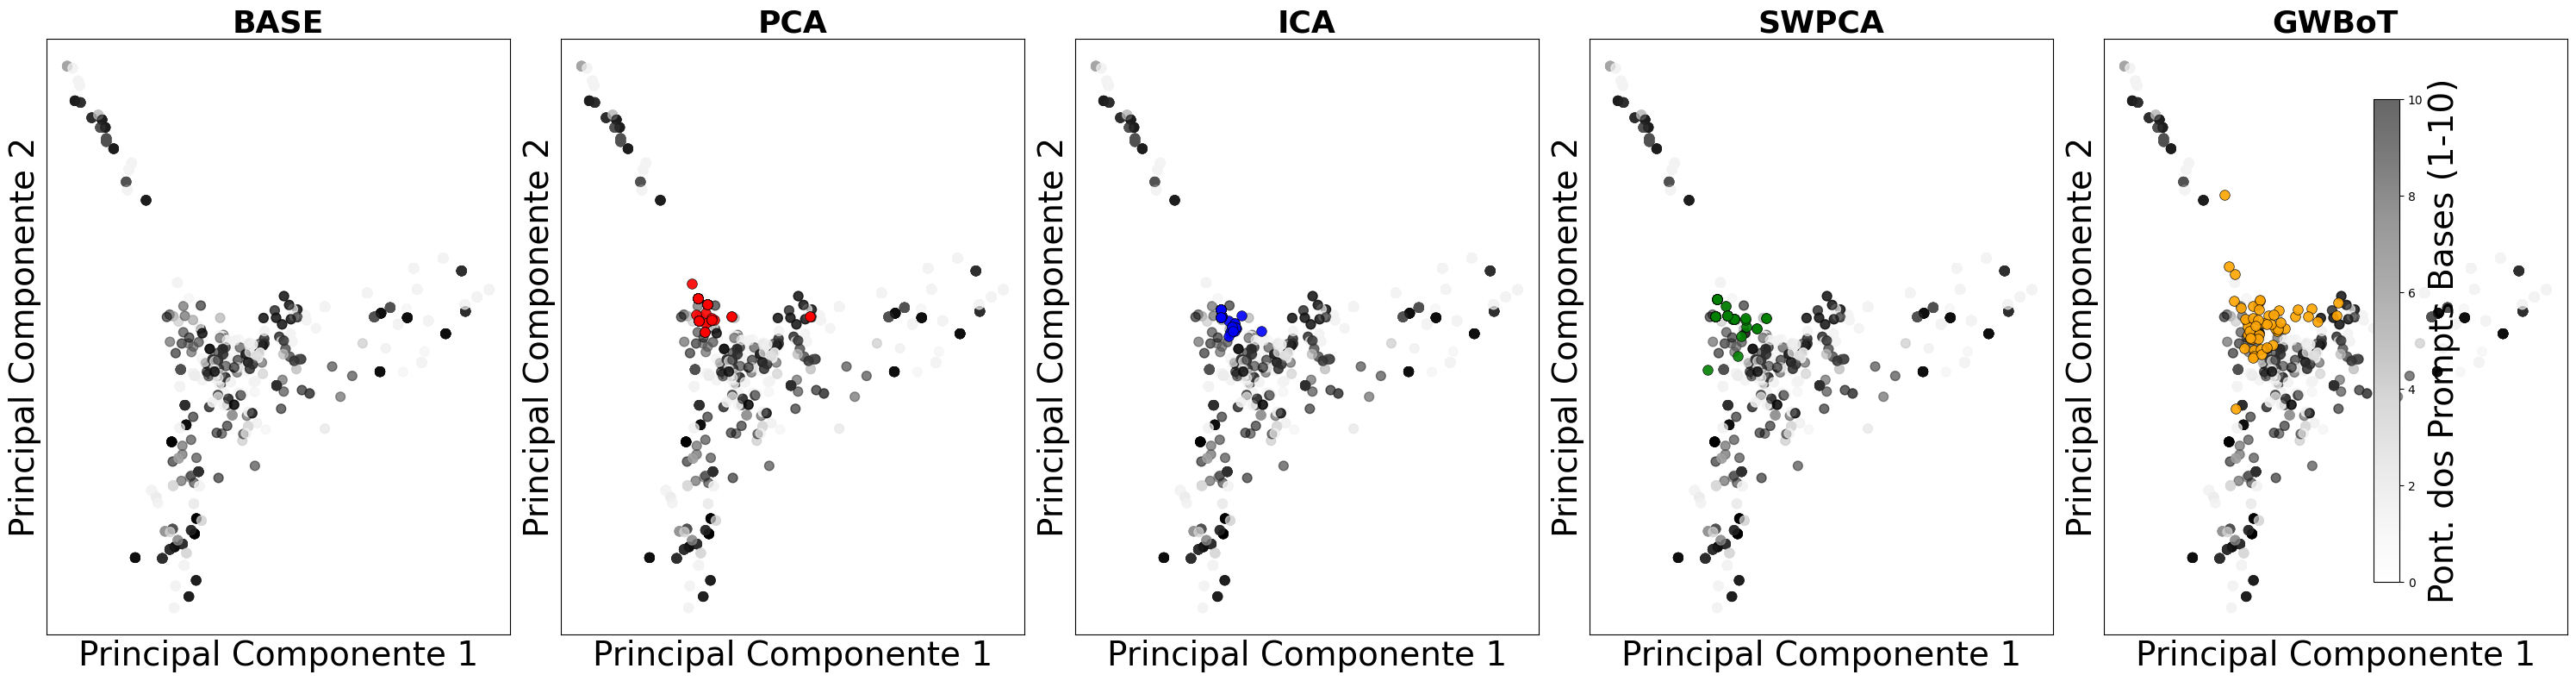

In [191]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# 1. Load Data
try:
    with open('final_results_without_metrics.json', 'r') as f:
        data = json.load(f)
except FileNotFoundError:
    print("Erro: Arquivo 'final_results_without_metrics.json' não encontrado.")
    data = {}

if data:
    texts = []
    labels = []
    scores = []  
    
    methods = ['pca', 'ica', 'score_weighted_pca', 'gradient_weighted']
    method_names = {
        'pca': 'PCA BoT',
        'ica': 'ICA BoT',
        'score_weighted_pca': 'SWPCA BoT',
        'gradient_weighted': 'GWBoT'
    }

    
    for request_id in range(50):
        str_id = str(request_id)
        if str_id not in data.get('pca', {}):
            continue

        gw_data = data.get('gradient_weighted', {}).get(str_id, {})
        base_prompts = gw_data.get('base_prompts', [])
        base_scores_list = gw_data.get('base_scores', [])
        
        if len(base_scores_list) != len(base_prompts):
            # Fallback: assume mean or 1 if missing. 
            # But let's try to use what matches.
            pass

        for i, bp in enumerate(base_prompts):
            texts.append(bp)
            labels.append('Base Prompts')
            
            s = base_scores_list[i] if i < len(base_scores_list) else 1
            scores.append(s)
            
        
        for method in methods:
            if str_id in data.get(method, {}):
                bot_list = data[method][str_id].get('BoT', [])
                if bot_list:
                    bot_str = " ".join(bot_list)
                    texts.append(bot_str)
                    labels.append(method_names[method])
                    scores.append(0) # Placeholder for methods (not used for coloring base prompts)

    
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)

    
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X.toarray())
    
    
    df_pca = pd.DataFrame(X_pca_2d, columns=['x', 'y'])
    df_pca['label'] = labels
    df_pca['score'] = scores

    
    # --- ALTERAÇÃO AQUI: Mudamos para 5 subplots e aumentamos a largura ---
    fig, axes = plt.subplots(1, 5, figsize=(30, 8))
    
    
    x_min, x_max = df_pca['x'].min(), df_pca['x'].max()
    y_min, y_max = df_pca['y'].min(), df_pca['y'].max()
    margin_x = (x_max - x_min) * 0.05
    margin_y = (y_max - y_min) * 0.05
    
    # --- ALTERAÇÃO AQUI: Adicionado o primeiro item como (None, None, 'Base Distribution') ---
    plot_configs = [
        (None, None, 'BASE'), # Primeiro gráfico apenas com a base
        ('PCA BoT', 'red', 'PCA'),
        ('ICA BoT', 'blue', 'ICA'),
        ('SWPCA BoT', 'green', 'SWPCA'),
        ('GWBoT', 'orange', 'GWBoT')
    ]
    
    for i, (method_label, color, title) in enumerate(plot_configs):
        ax = axes[i]
        
        # 1. Plotar Base Prompts (Sempre acontece, em todos os gráficos)
        base_data = df_pca[df_pca['label'] == 'Base Prompts']
        
        sc = ax.scatter(
            base_data['x'], base_data['y'],
            c=base_data['score'], 
            cmap='Greys', 
            vmin=0, vmax=10,  
            alpha=0.6,        
            s=60, 
            label='Base Prompts (Score)',
            rasterized=True
        )
        
        # --- ALTERAÇÃO AQUI: Plotar o método apenas se method_label não for None ---
        if method_label is not None:
            method_data = df_pca[df_pca['label'] == method_label]
            ax.scatter(
                method_data['x'], method_data['y'],
                c=color, alpha=0.9, s=70, label=title,
                edgecolors='k', linewidth=0.5
            )
        
      
        ax.set_title(title, fontsize=26, fontweight='bold')
        ax.set_xlabel('Principal Componente 1', fontsize=28)
        ax.set_ylabel('Principal Componente 2', fontsize=28)
        
        ax.set_xlim(x_min - margin_x, x_max + margin_x)
        ax.set_ylim(y_min - margin_y, y_max + margin_y)
        
        ax.set_xticks([])
        ax.set_yticks([])

    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7]) # [left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Pont. dos Prompts Bases (1-10)', fontsize=28)

    plt.subplots_adjust(right=0.9)

    output_filename = "plots/resultado1.pdf"
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Gráfico salvo: {output_filename}")

else:
    print("Sem dados.")

### Resultado VRAM

In [192]:
import pandas as pd
import json
with open("autodan_metrics_completo.json", "r") as f:
    autodan_data = json.load(f)
with open("scorer_performance_metrics.json", "r") as f:
    scorer_data = json.load(f)

In [193]:
import numpy as np

def get_avg_allocation(gpu_metrics):
    total_avg = 0.0
    for gpu_id, content in gpu_metrics.items():
        snapshots = content.get('snapshots', [])
        if snapshots:
                allocs = [s.get('memory_reserved_mb', 0)  for s in snapshots]
                total_avg += np.mean(allocs)
        print(np.mean(allocs))
    return total_avg


In [194]:
autodan_metrics = pd.DataFrame(autodan_data["detailed_metrics"])

In [195]:
autodan_metrics['avg_allocated_mb'] = autodan_metrics['gpu_metrics'].apply(get_avg_allocation)
result = autodan_metrics.groupby('operation')['avg_allocated_mb'].mean().reset_index()

7408.376237623763
8954.29702970297
8766.296774193548
9457.148387096775
7458.0
9024.0
8059.232876712329
8716.575342465754
7458.0
9024.0
8360.666666666666
9028.32679738562
7750.942446043166
9414.589928057554
7752.0
9416.0
8450.540229885057
9124.218390804597
7752.0
9416.0
8482.22619047619
9171.797619047618
7752.0
9416.0
7752.0
9416.0
8084.918918918919
8716.621621621622
7752.0
9416.0
8047.5641025641025
8701.0
7752.0
9416.0
8299.945945945947
8953.603603603604
7752.0
9416.0
7752.0
9416.0
8084.5970149253735
8716.268656716418
7752.0
9416.0
8255.283783783783
8907.027027027027
7752.0
9430.0
7752.0
9430.0
8098.463768115942
8732.144927536232
7752.0
9430.0
8450.61797752809
9124.303370786516
7752.0
9430.0
7752.0
9430.0
8480.491228070176
9169.807017543859
7752.0
9430.0
8429.68888888889
9103.274074074074
7754.0
9430.0
8371.592592592593
9040.864197530864
7754.0
9430.0
8059.194444444444
8716.527777777777
7754.0
9430.0
8508.852713178294
9202.279069767443
7762.0
9430.0
8507.712918660287
9200.937799043062


In [196]:
result

,operation,avg_allocated_mb
0,attacker_initial_prompt_generation,19037.973465
1,attacker_strategy_guided_generation,19724.560000
2,scorer_generation,17464.672231
3,summarizer_strategy_extraction,19515.609476


In [197]:
mean_allocated = 0.0
for idx, row in result.iterrows():
    if row["operation"] != "scorer_generation":
        mean_allocated += row["avg_allocated_mb"]
mean_allocated = mean_allocated / 3

In [198]:
mean_allocated

19426.047647184543

In [199]:
autodan_gpu_use = mean_allocated + result[result["operation"] == "scorer_generation"]["avg_allocated_mb"]

In [200]:
autodan_gpu_use

2    36890.719878
Name: avg_allocated_mb, dtype: float64

In [201]:
with open("final_results.json", "r") as f:
    final_results = json.load(f)

In [202]:

def get_avg_allocation_pi(gpu_metrics):
    if not gpu_metrics: return 0.0
    total = 0.0
    for gpu in gpu_metrics.values():
        snapshots = gpu.get('snapshots', [])
        if snapshots:
            total += np.mean([s['memory_reserved_mb']  for s in snapshots])
    return total


approach_means = {}
for item in final_results:
    for approach, data in item.items():
        metrics = data['prompt_generation_cost']['gpu_metrics']
        avg_mb = get_avg_allocation_pi(metrics)
        
        if approach not in approach_means: approach_means[approach] = []
        approach_means[approach].append(avg_mb)

# Exibição dos resultados
for approach, values in approach_means.items():
    print(f"{approach}: {np.mean(values):.2f} MB")

pca: 18705.47 MB
ica: 18710.46 MB
score_weighted_pca: 18384.11 MB
gradient_weighted: 18318.47 MB


/tmp/ipykernel_3463/794650378.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='VRAM Usage (MB)', data=df, palette='viridis')


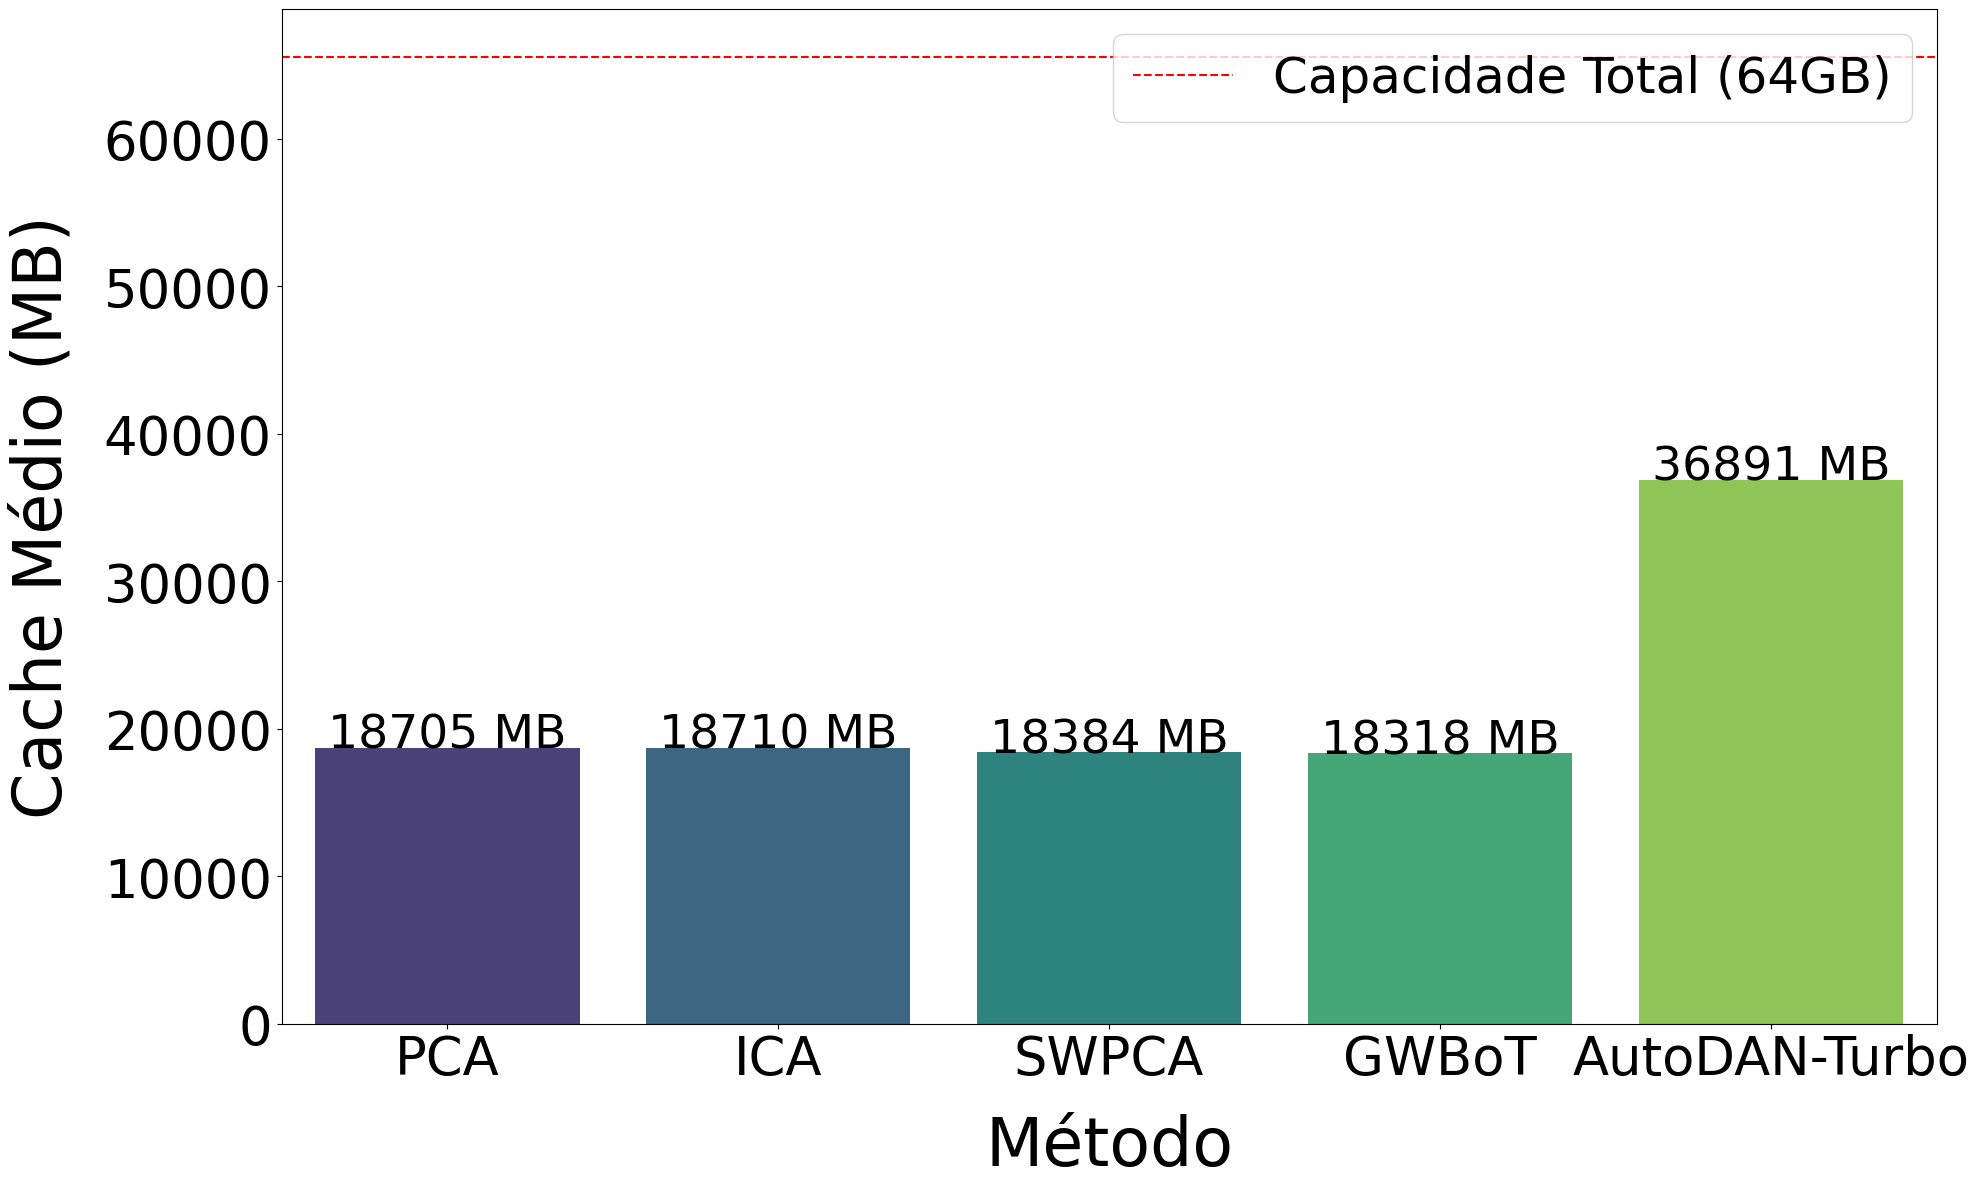

In [203]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Create the directory if it doesn't exist (to match user path)
os.makedirs('plots', exist_ok=True)

# Data provided by the user
data = {
    'Method': ['PCA', 'ICA', 'SWPCA', 'GWBoT', 'AutoDAN-Turbo'],
    'VRAM Usage (MB)': [18705.47, 18710.46, 18384.11, 18318.47, 36890.719878]
}

df = pd.DataFrame(data)

plt.figure(figsize=(20, 12)) # Aumentei um pouco a figura para acomodar melhor fontes maiores
ax = sns.barplot(x='Method', y='VRAM Usage (MB)', data=df, palette='viridis')

# 1. Aumentar tamanho da legenda dos eixos (X e Y)
# Alterar o parâmetro 'fontsize' aqui
plt.xlabel('Método', fontsize=48, labelpad=20) 
plt.ylabel('Cache Médio (MB)', fontsize=48, labelpad=20)

# 2. Legendas das abordagens (eixo X): Retas e maiores
# 'rotation=0' deixa reto. 'fontsize' controla o tamanho.
plt.xticks(rotation=0, fontsize=38)
plt.yticks(fontsize=38)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f} MB', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=34) # Opcional: aumentar fonte dos valores

# Add a horizontal line for the 64GB (Total Capacity) reference
plt.axhline(y=65536, color='r', linestyle='--', label='Capacidade Total (64GB)')

# 3. Ajustar posição da legenda da linha tracejada
# 'loc="upper right"' força o canto superior direito
plt.legend(loc='upper right', fontsize=36)
#plt.ylim(0, max(data['VRAM Usage (MB)']) * 1.15)
plt.tight_layout()
# Saving as PDF as requested
plt.savefig('plots/vram_usage_comparison.pdf')

In [204]:
### AVG PERCENT USE
autodan_data_summary = pd.DataFrame(autodan_data["summary"])
scorer_data_summary = pd.DataFrame(scorer_data["summary"]["scorer_generation"])

In [205]:
attacker_initial_gpu_use_0, attacker_initial_gpu_use_1 = autodan_data_summary["attacker_initial_prompt_generation"]["gpu_summary"]["gpu_0"]["avg_utilization"], autodan_data_summary["attacker_initial_prompt_generation"]["gpu_summary"]["gpu_1"]["avg_utilization"]
attacker_initial_gpu_peak_use_0, attacker_initial_gpu_peak_use_1 = autodan_data_summary["attacker_initial_prompt_generation"]["gpu_summary"]["gpu_0"]["avg_peak_utilization"], autodan_data_summary["attacker_initial_prompt_generation"]["gpu_summary"]["gpu_1"]["avg_peak_utilization"]
attacker_strategy_gpu_use_0, attacker_strategy_gpu_use_1 = autodan_data_summary["attacker_strategy_guided_generation"]["gpu_summary"]["gpu_0"]["avg_utilization"], autodan_data_summary["attacker_strategy_guided_generation"]["gpu_summary"]["gpu_1"]["avg_utilization"]
attacker_strategy_gpu_peak_use_0, attacker_strategy_gpu_peak_use_1 = autodan_data_summary["attacker_strategy_guided_generation"]["gpu_summary"]["gpu_0"]["avg_peak_utilization"], autodan_data_summary["attacker_strategy_guided_generation"]["gpu_summary"]["gpu_1"]["avg_peak_utilization"]

In [206]:
summarizer_strategy_gpu_use_0, summarizer_strategy_gpu_use_1 = autodan_data_summary["summarizer_strategy_extraction"]["gpu_summary"]["gpu_0"]["avg_utilization"], autodan_data_summary["summarizer_strategy_extraction"]["gpu_summary"]["gpu_1"]["avg_utilization"]
summarizer_strategy_gpu_peak__use_0, summarizer_strategy_gpu_peak_use_1 = autodan_data_summary["summarizer_strategy_extraction"]["gpu_summary"]["gpu_0"]["avg_peak_utilization"], autodan_data_summary["summarizer_strategy_extraction"]["gpu_summary"]["gpu_1"]["avg_peak_utilization"]

In [207]:
scorer_generation_gpu_use_0, scorer_generation_gpu_use_1 = scorer_data_summary["gpu_summary"]["gpu_0"]["avg_utilization"], scorer_data_summary["gpu_summary"]["gpu_1"]["avg_utilization"]
scorer_generation_gpu_peak_use_0, scorer_generation_gpu_peak_use_1 = scorer_data_summary["gpu_summary"]["gpu_0"]["avg_peak_utilization"], scorer_data_summary["gpu_summary"]["gpu_1"]["avg_peak_utilization"]

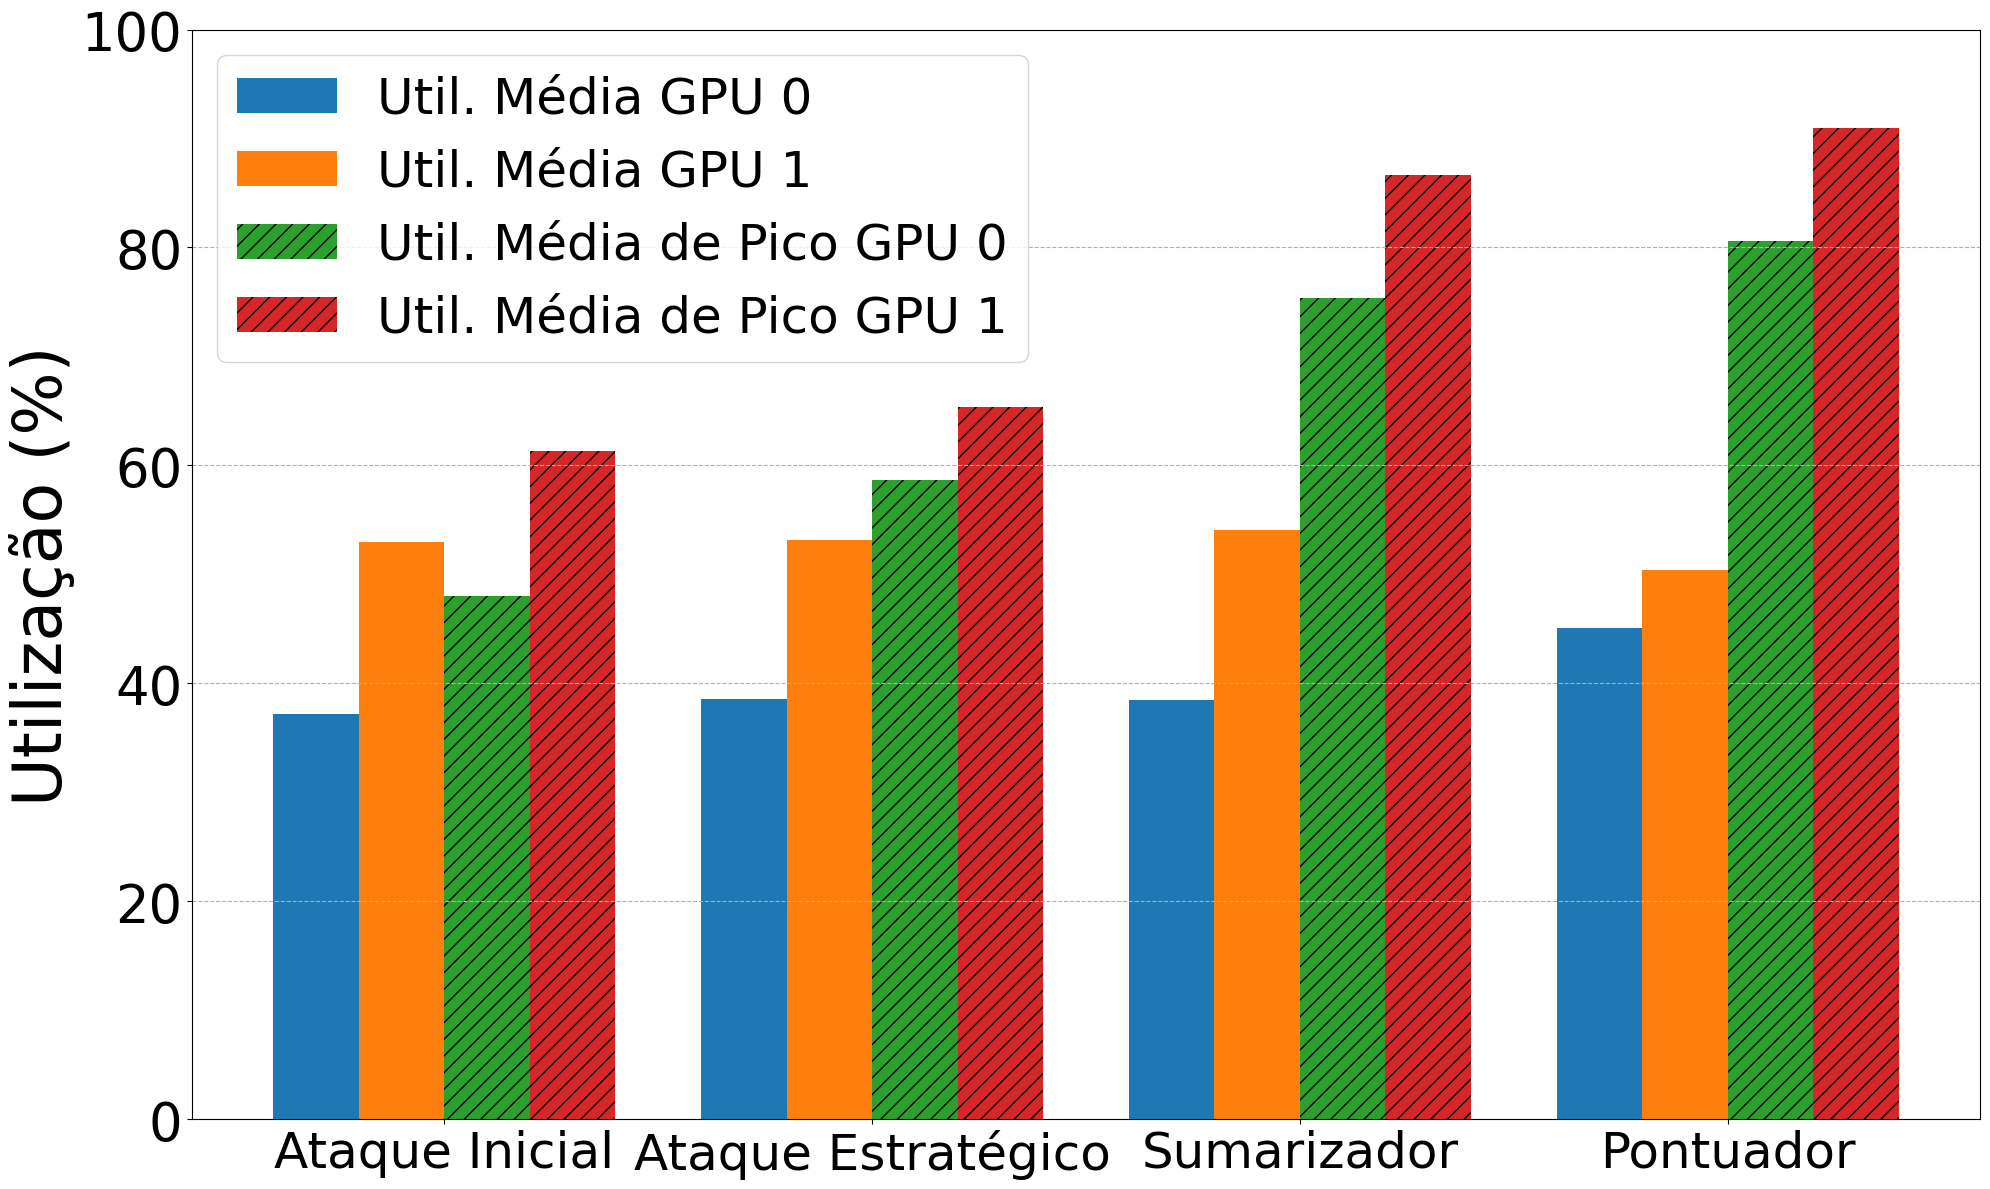

In [216]:
# --- 2. Preparação para o Gráfico ---

# Definindo as etapas (Eixo X)
stages = ['Ataque Inicial', 'Ataque Estratégico', 'Sumarizador', 'Pontuador']
x = np.arange(len(stages))  # Localização dos rótulos
width = 0.2  # Largura de cada barra

# Organizando as variáveis em listas correspondentes a cada tipo de métrica para plotagem
# Ordem das listas segue a ordem das etapas: [Initial, Strategy, Summarizer, Scorer]

# Lista 1: Média GPU 0
avg_gpu_0_values = [
    attacker_initial_gpu_use_0,
    attacker_strategy_gpu_use_0,
    summarizer_strategy_gpu_use_0,
    scorer_generation_gpu_use_0
]

# Lista 2: Média GPU 1
avg_gpu_1_values = [
    attacker_initial_gpu_use_1,
    attacker_strategy_gpu_use_1,
    summarizer_strategy_gpu_use_1,
    scorer_generation_gpu_use_1
]

# Lista 3: Pico Médio GPU 0
peak_gpu_0_values = [
    attacker_initial_gpu_peak_use_0,
    attacker_strategy_gpu_peak_use_0,
    summarizer_strategy_gpu_peak__use_0, # Váriavel com __
    scorer_generation_gpu_peak_use_0
]

# Lista 4: Pico Médio GPU 1
peak_gpu_1_values = [
    attacker_initial_gpu_peak_use_1,
    attacker_strategy_gpu_peak_use_1,
    summarizer_strategy_gpu_peak_use_1,
    scorer_generation_gpu_peak_use_1
]

# --- 3. Plotagem do Gráfico ---

fig, ax = plt.subplots(figsize=(20, 12))

# Criando as 4 barras para cada grupo
rects1 = ax.bar(x - 1.5*width, avg_gpu_0_values, width, label='Util. Média GPU 0')
rects2 = ax.bar(x - 0.5*width, avg_gpu_1_values, width, label='Util. Média GPU 1')
rects3 = ax.bar(x + 0.5*width, peak_gpu_0_values, width, label='Util. Média de Pico GPU 0', hatch='//') # Hatch para diferenciar Pico
rects4 = ax.bar(x + 1.5*width, peak_gpu_1_values, width, label='Util. Média de Pico GPU 1', hatch='//')

# Adicionando textos, rótulos e título
ax.set_ylabel('Utilização (%)', fontsize=48)
ax.set_xticks(x)
plt.xticks(rotation=0, fontsize=36)
plt.yticks(fontsize=38)
plt.ylim(0, 100)
ax.set_xticklabels(stages)
ax.legend(fontsize=36)

# Adiciona grid horizontal para facilitar leitura
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
output_filename = 'plots/comparacao_uso_autodan.pdf'
plt.savefig(output_filename)

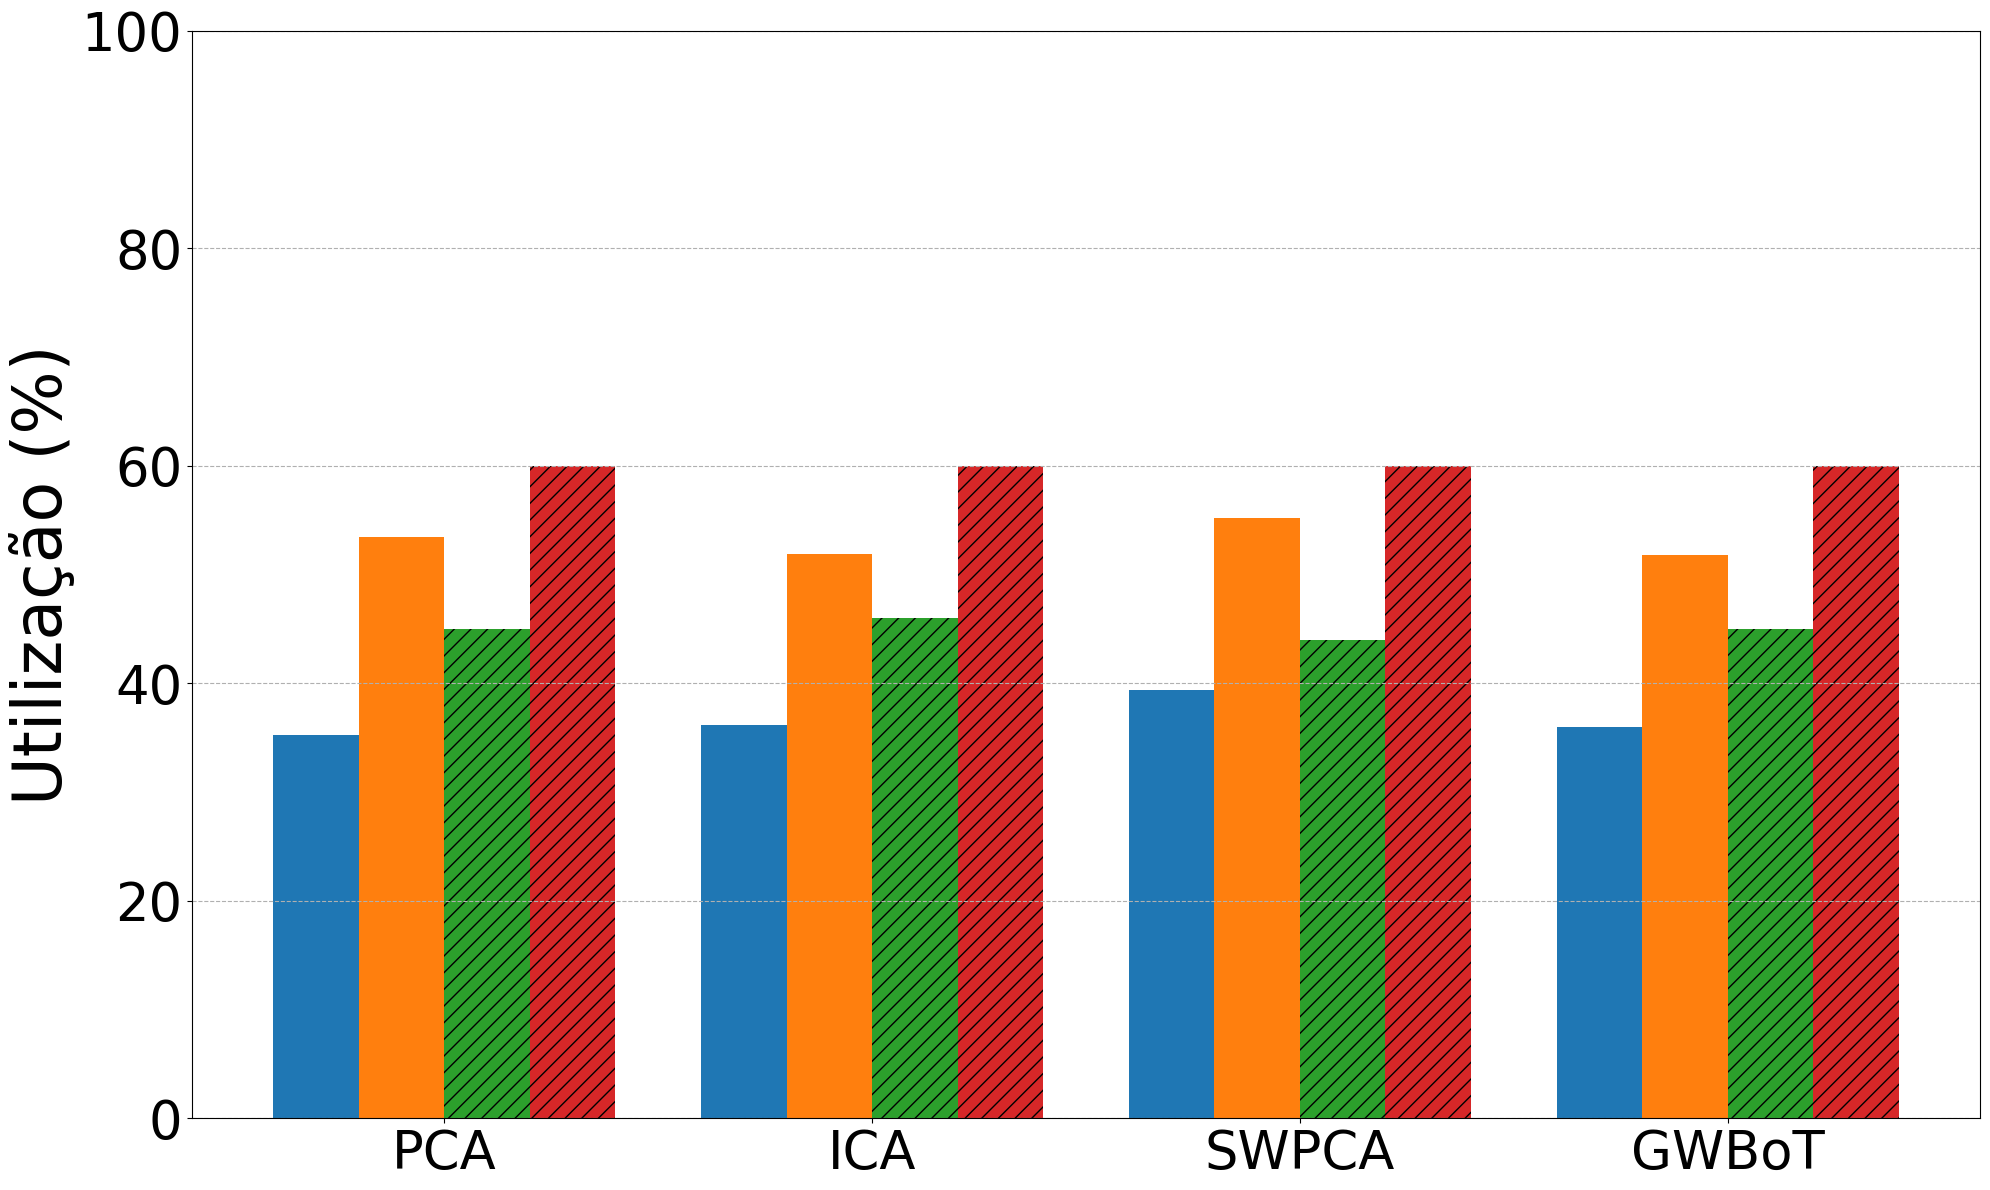

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Load data
try:
    with open('final_results.json', 'r') as f:
        data = json.load(f)
    
    # Use the first entry
    entry = data[0]

    # Mapping approaches to display names
    approach_map = {
        'pca': 'PCA',
        'ica': 'ICA',
        'score_weighted_pca': 'SWPCA',
        'gradient_weighted': 'GWBoT'
    }

    # The specific stage we want
    target_stage_key = 'prompt_generation_cost'
    target_stage_title = 'Prompt Generation GPU Utilization'

    # Data structure to hold extracted values
    data_to_plot = {'avg_0': [], 'avg_1': [], 'peak_0': [], 'peak_1': []}

    approaches_ordered = ['pca', 'ica', 'score_weighted_pca', 'gradient_weighted']
    labels = [approach_map[a] for a in approaches_ordered]

    for app in approaches_ordered:
        if app not in entry:
            for k in data_to_plot: data_to_plot[k].append(0)
            continue
            
        app_data = entry[app]
        
        if target_stage_key in app_data:
            metrics = app_data[target_stage_key].get('gpu_metrics', {})
            
            # GPU 0
            g0 = metrics.get('0', {})
            data_to_plot['avg_0'].append(g0.get('avg_utilization_percent', 0))
            data_to_plot['peak_0'].append(g0.get('peak_utilization_percent', 0))
            
            # GPU 1
            g1 = metrics.get('1', {})
            data_to_plot['avg_1'].append(g1.get('avg_utilization_percent', 0))
            data_to_plot['peak_1'].append(g1.get('peak_utilization_percent', 0))
        else:
            for k in data_to_plot: data_to_plot[k].append(0)

    # Plotting - Single Chart
    fig, ax = plt.subplots(figsize=(20, 12))

    x = np.arange(len(labels))
    width = 0.2

    rects1 = ax.bar(x - 1.5*width, data_to_plot['avg_0'], width, label='Avg GPU 0')
    rects2 = ax.bar(x - 0.5*width, data_to_plot['avg_1'], width, label='Avg GPU 1')
    rects3 = ax.bar(x + 0.5*width, data_to_plot['peak_0'], width, label='Peak GPU 0', hatch='//')
    rects4 = ax.bar(x + 1.5*width, data_to_plot['peak_1'], width, label='Peak GPU 1', hatch='//')

    ax.set_ylabel('Utilização (%)', fontsize=48)
    ax.set_xticks(x)
    plt.xticks(rotation=0, fontsize=38)
    plt.yticks(fontsize=38)
    ax.set_xticklabels(labels)
    #ax.legend(fontsize=22, loc="upper left")
    ax.grid(axis='y', linestyle='--')

    # Set Y axis limit
    ax.set_ylim(0, 100)

    plt.tight_layout()
    plt.savefig('plots/prompt_inheritance_gpu_utilization_prompt_generation.pdf')

except Exception as e:
    print(f"Error: {e}")

## Resultado 2

Method keys found: ['pca', 'ica', 'score_weighted_pca', 'gradient_weighted']


/tmp/ipykernel_3463/1330416925.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(data_to_plot, patch_artist=True, labels=labels)


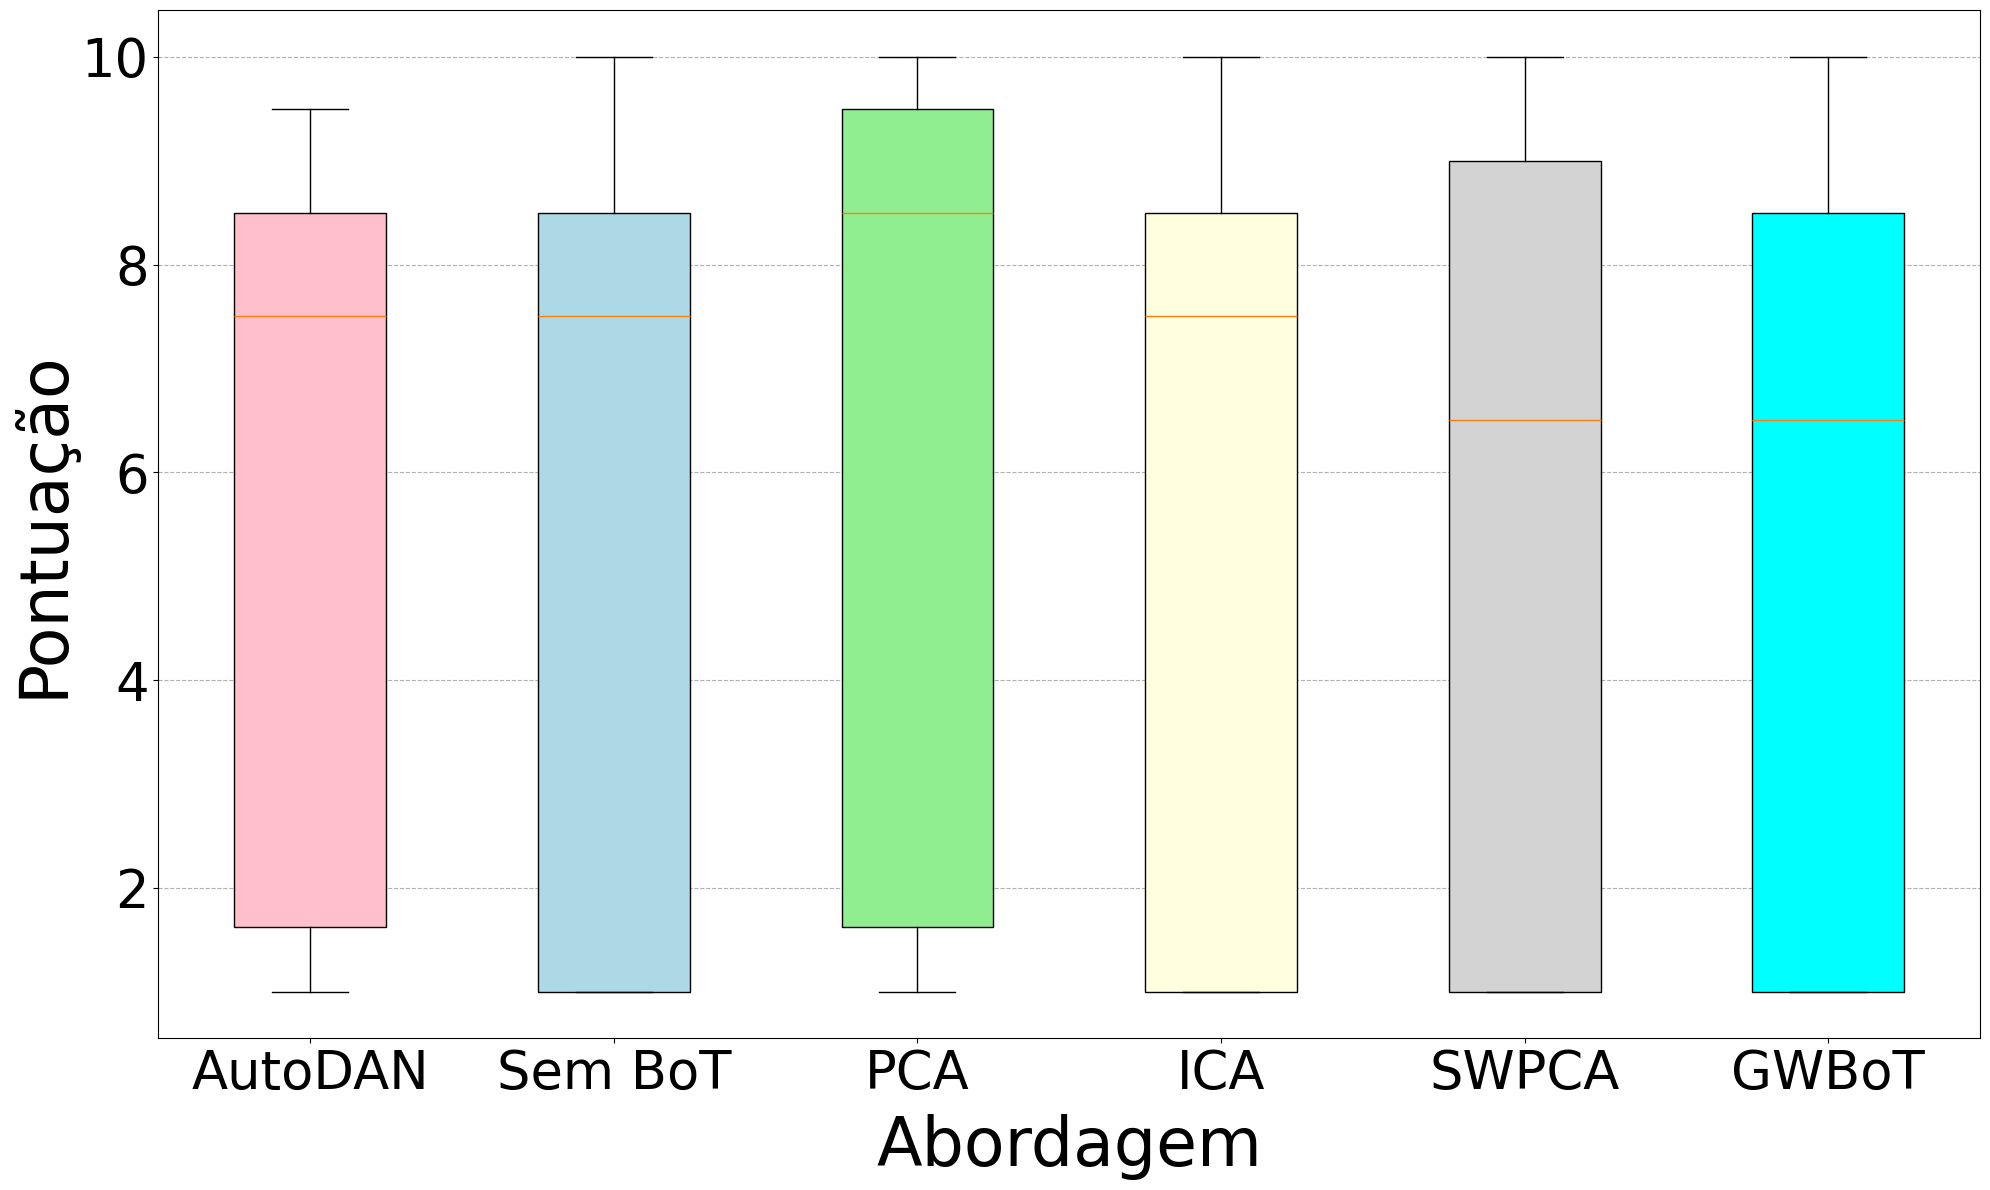

In [210]:
import json
import matplotlib.pyplot as plt

# Load files
with open("adn_attack_logs.json", "r") as f:
    autodan_data = json.load(f)

with open("final_results_base_test.json", "r") as f:
    base_test_data = json.load(f)

with open("final_results_without_metrics.json", "r") as f:
    methods_data = json.load(f)

# Get method keys to decide on renaming
method_keys = list(methods_data.keys())
print("Method keys found:", method_keys)

# Define a mapping for better display
name_mapping = {
    'pca': 'PCA',
    'ica': 'ICA',
    'score_weighted_pca': 'SWPCA',
    'gradient_weighted': 'GWBoT',
    # Add generic fallback just in case
}

def format_label(key):
    # Use mapping if exists
    if key in name_mapping:
        return name_mapping[key]
    # Fallback: replace underscores with spaces and title case
    return key.replace('_', ' ').title()

# Extract scores
data_to_plot = []
labels = []

# 1. AutoDAN
autodan_scores = [entry.get('score', 0) for entry in autodan_data if 'score' in entry]
data_to_plot.append(autodan_scores)
labels.append("AutoDAN")

# 2. Base Test
base_scores = []
for entry in base_test_data:
    if 'scores' in entry:
        base_scores.extend(entry['scores'])
data_to_plot.append(base_scores)
labels.append("Sem BoT")

# 3. Other Approaches
for method_name in method_keys:
    method_content = methods_data[method_name]
    method_scores = []
    for key, entry in method_content.items():
        if isinstance(entry, dict) and 'scores' in entry:
            method_scores.extend(entry['scores'])
    
    data_to_plot.append(method_scores)
    # Apply renaming here
    labels.append(format_label(method_name))

# Plotting
plt.figure(figsize=(20, 12))
bplot = plt.boxplot(data_to_plot, patch_artist=True, labels=labels)

colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgrey', 'cyan', 'orange', 'purple']
for i, patch in enumerate(bplot['boxes']):
    color = colors[i % len(colors)]
    patch.set_facecolor(color)

plt.ylabel('Pontuação', fontsize=48)
plt.xlabel('Abordagem', fontsize=48, labelpad=10)
plt.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=0, fontsize=38)
plt.yticks(fontsize=38)

output_filename = 'plots/scores_comparison_boxplot_.pdf'
plt.tight_layout()
plt.savefig(output_filename)



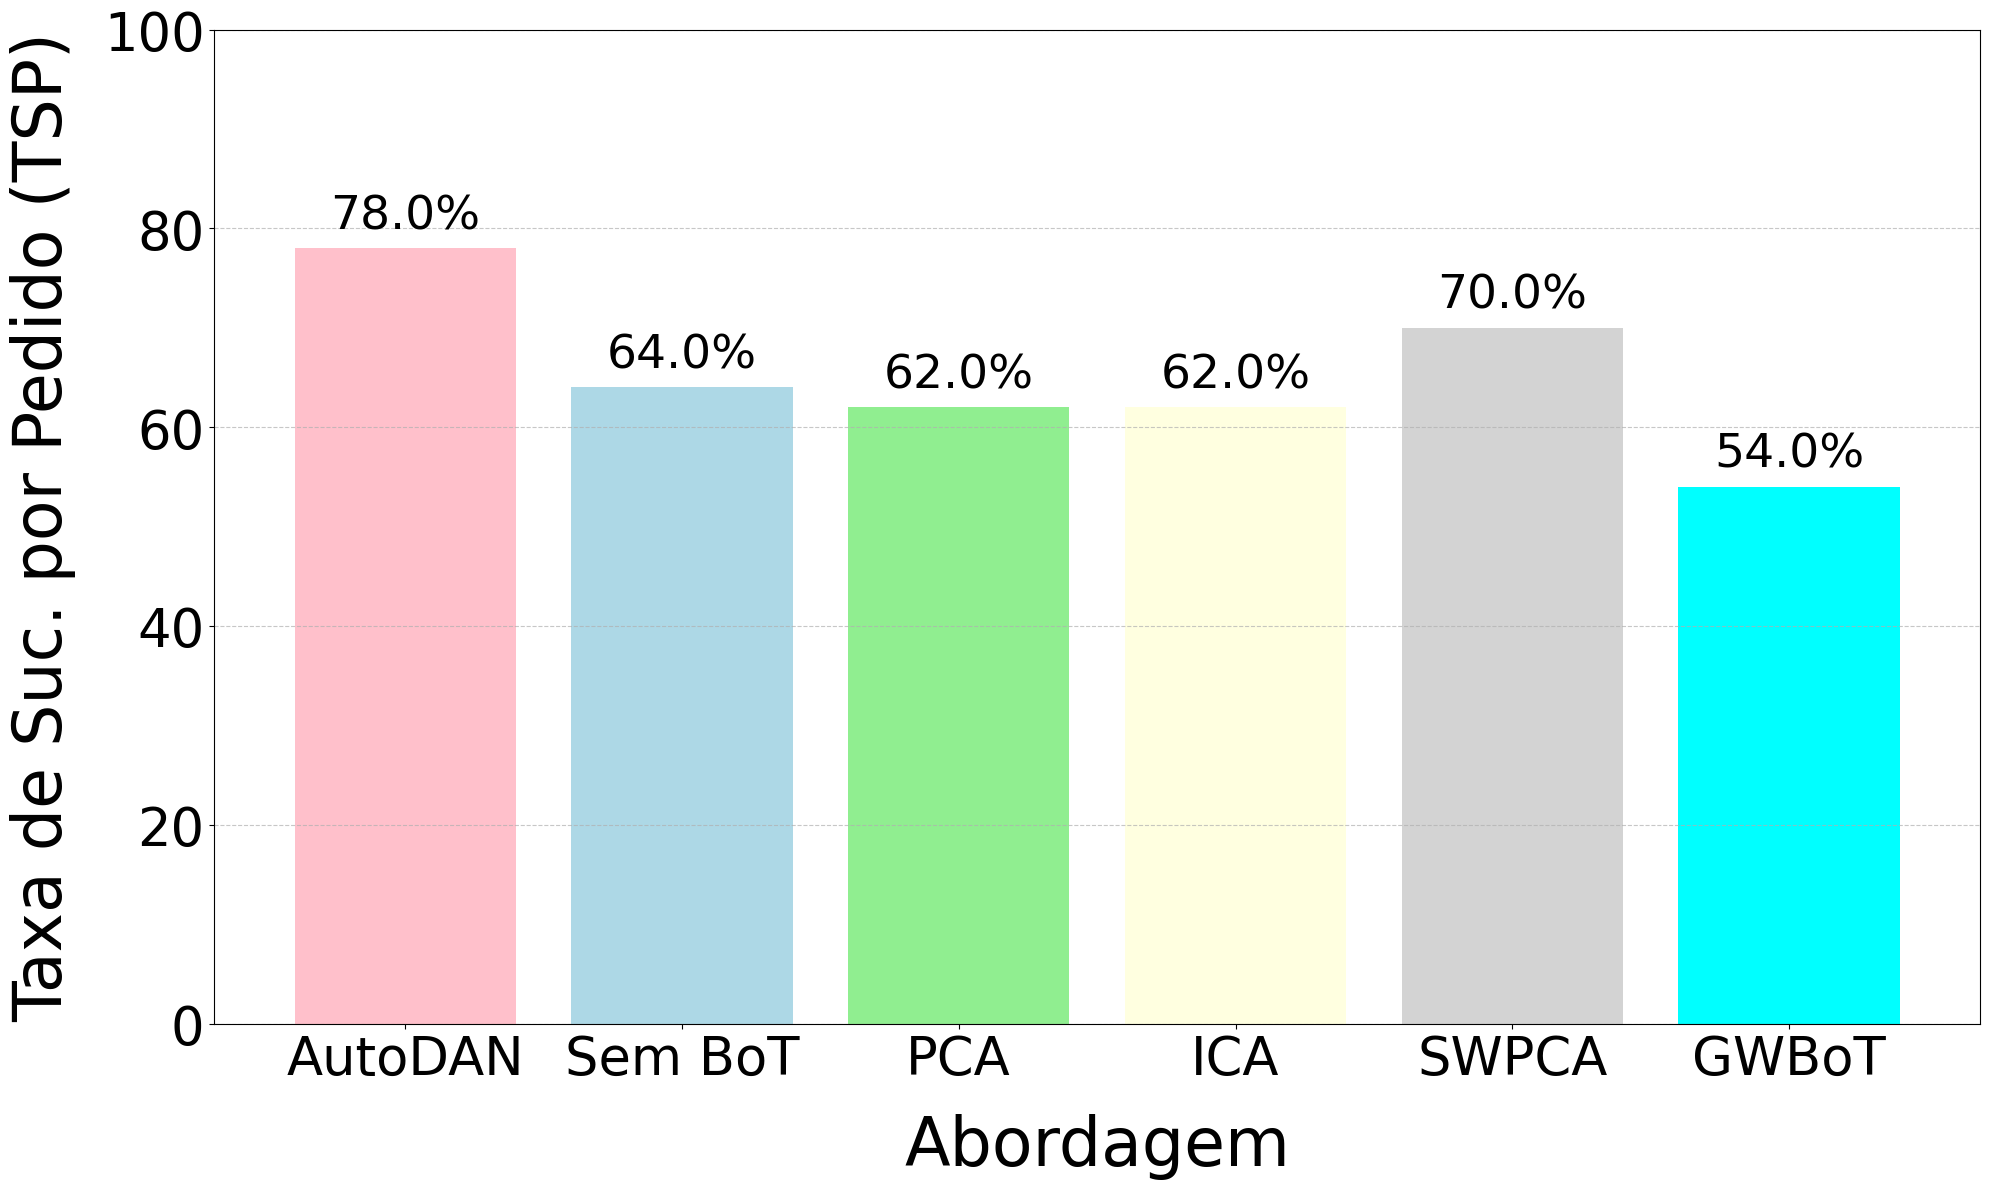

In [219]:
import matplotlib.pyplot as plt

# Data provided by the user
data = {
    'AutoDAN': 78.0,
    'Sem BoT': 64.0,
    'PCA': 62.0,
    'ICA': 62.0,
    'SWPCA': 70.0,
    'GWBoT': 54.0
}

labels = list(data.keys())
values = list(data.values())

# Plotting
plt.figure(figsize=(20, 12))
bars = plt.bar(labels, values, color=['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgrey', 'cyan'])

# Add title and axis labels
plt.ylabel('Taxa de Suc. por Pedido (TSP)', fontsize=48, labelpad=20)
plt.xlabel('Abordagem', fontsize=48, labelpad=20)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontsize=34)

# Adjust layout
plt.ylim(0, 100)  # Assuming percentage goes up to 100
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=38)
plt.yticks(fontsize=38)
# Save the plot
output_filename = 'plots/tsp_comparison_barchart.pdf'
plt.tight_layout()
plt.savefig(output_filename)


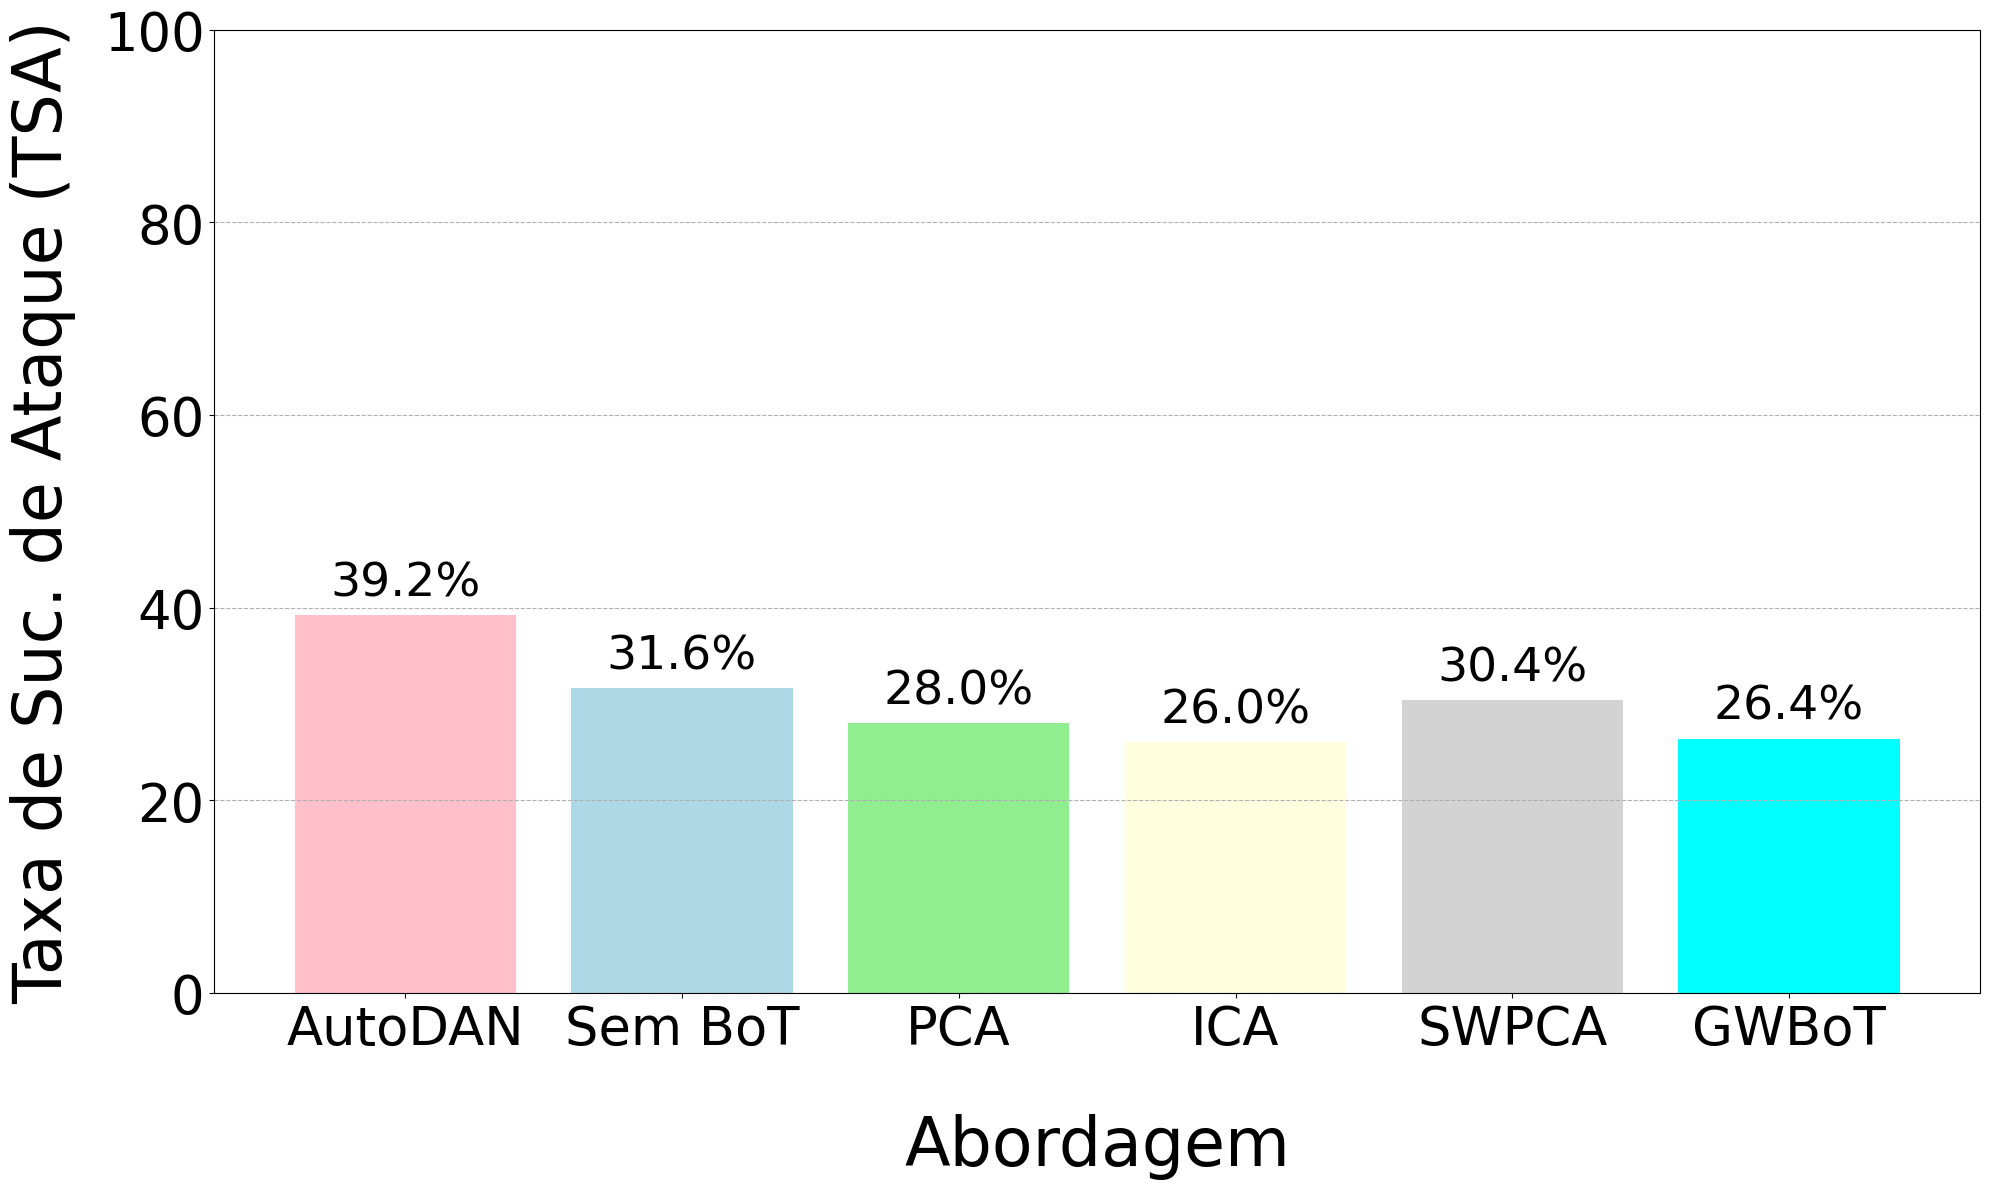

In [220]:
import matplotlib.pyplot as plt

# Data provided by the user
data = {
    'AutoDAN': 39.2,
    'Sem BoT': 31.6,
    'PCA': 28.0,
    'ICA': 26.0,
    'SWPCA': 30.4,
    'GWBoT': 26.4
}

labels = list(data.keys())
values = list(data.values())

# Plotting
plt.figure(figsize=(20, 12))
bars = plt.bar(labels, values, color=['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgrey', 'cyan'])

# Add title and axis labels
plt.ylabel('Taxa de Suc. de Ataque (TSA)', fontsize=48, labelpad=20)
plt.xlabel('Abordagem', fontsize=48, labelpad=42)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontsize=34)

# Adjust layout
plt.ylim(0, 100)  # Assuming percentage goes up to 100
plt.grid(True, axis='y', linestyle='--')
#plt.xticks(fontsize=16)
plt.xticks(fontsize=38)
plt.yticks(fontsize=38)
# Save the plot
output_filename = 'plots/tsa_comparison_barchart.pdf'
plt.tight_layout()
plt.savefig(output_filename)


/tmp/ipykernel_3463/4119082371.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_combined, x='Approach', y='Time', palette='viridis')


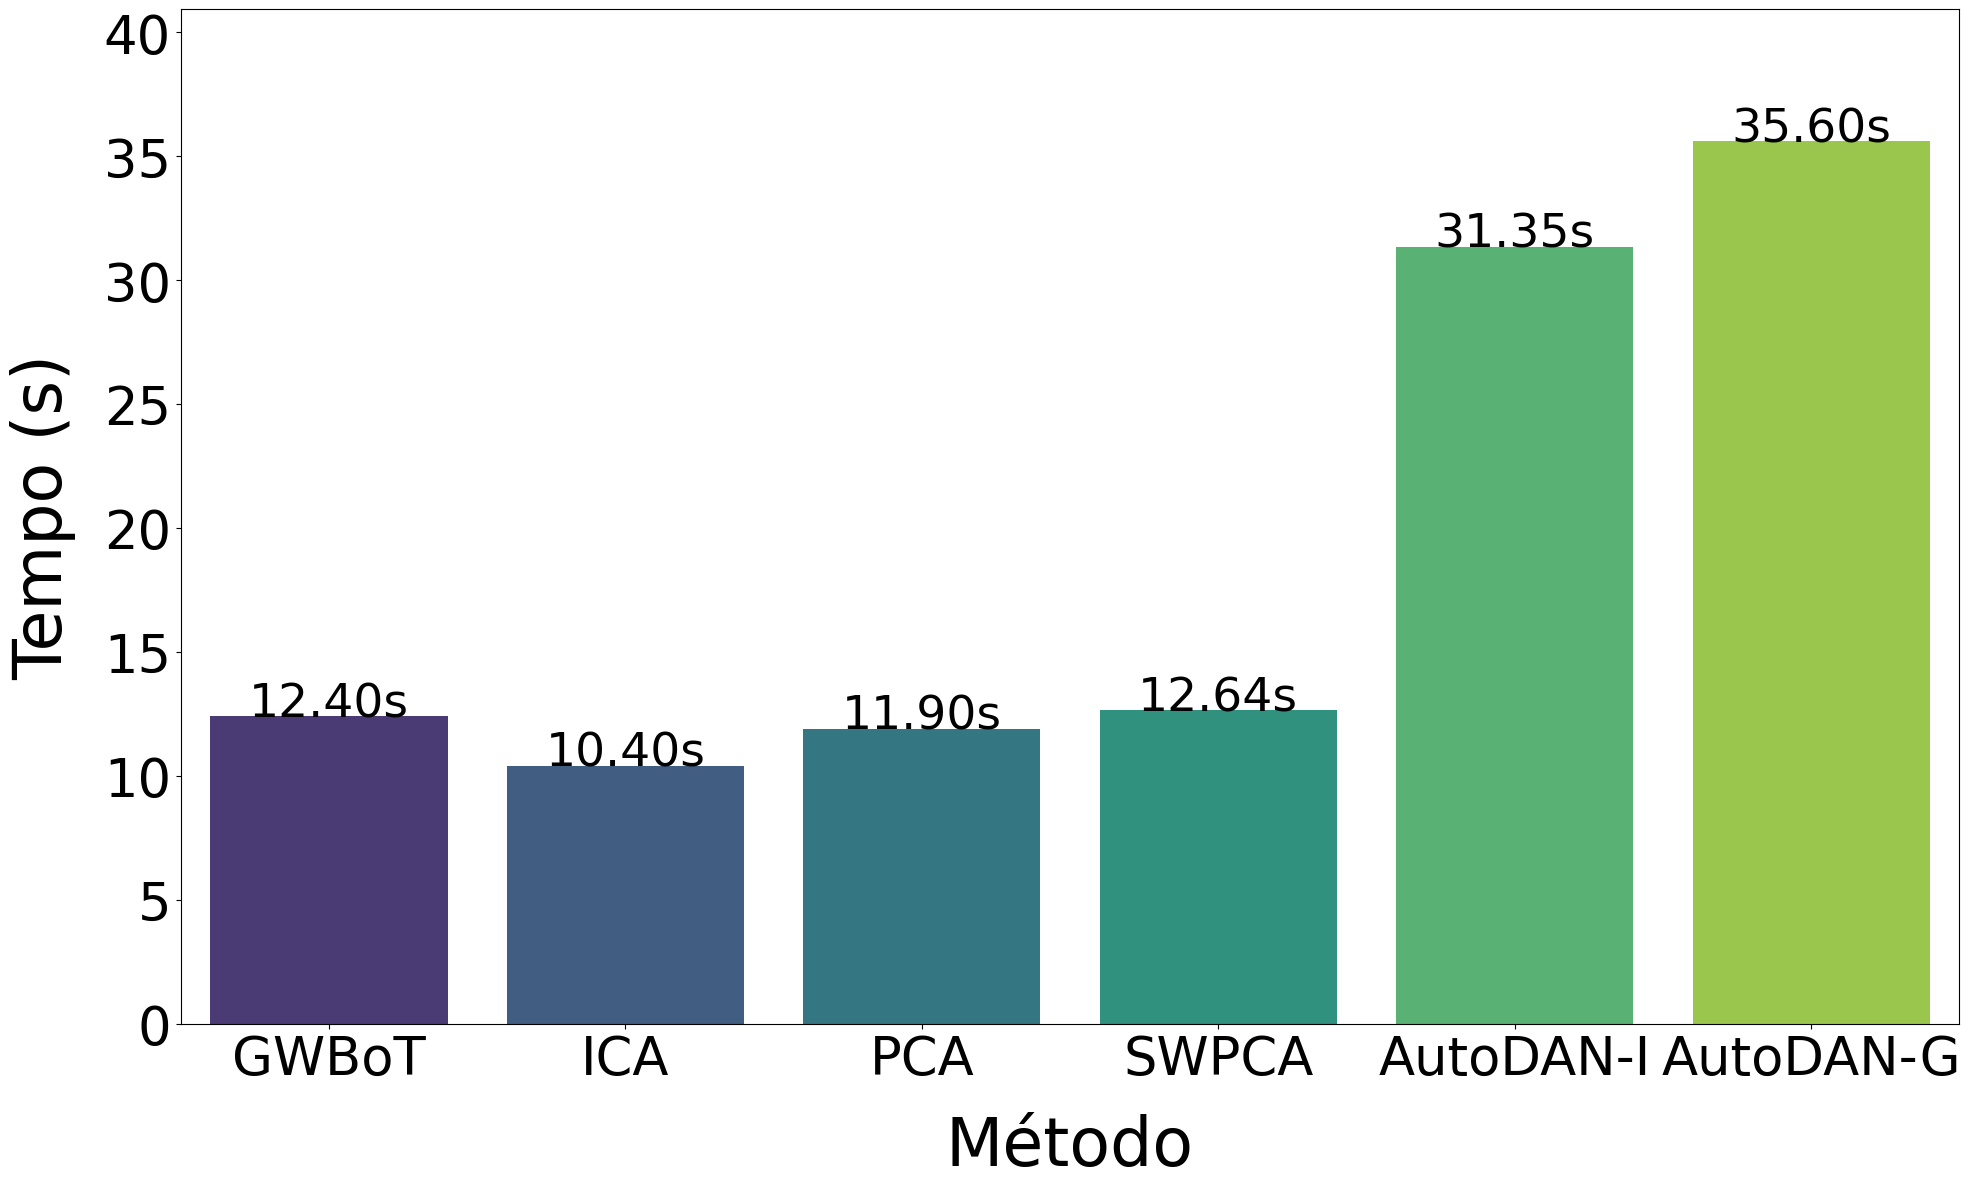

In [213]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Create the directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# 1. Carregar os ficheiros
try:
    with open('final_results.json', 'r') as f:
        data_final = json.load(f)
    with open('autodan_metrics_completo.json', 'r') as f:
        data_autodan = json.load(f)
except FileNotFoundError:
    print("Erro: Certifique-se de que os ficheiros .json estão na mesma pasta.")
    data_final = []
    data_autodan = {}

# --- Processamento 1: Final Results (PCA, ICA, etc.) ---

# Mapeamento
approach_map = {
    'pca': 'PCA',
    'ica': 'ICA',
    'score_weighted_pca': 'SWPCA',
    'gradient_weighted': 'GWBoT'
}

final_times = []

for item in data_final:
    for json_key, display_name in approach_map.items():
        if json_key in item:
            if 'prompt_generation_cost' in item[json_key]:
                t = item[json_key]['prompt_generation_cost']['wall_time_seconds']
                final_times.append({
                    'Approach': display_name,
                    'Time': t
                })

df_final = pd.DataFrame(final_times)

# Verificação de segurança
if df_final.empty:
    print("Aviso: Nenhum dado encontrado para as abordagens especificadas.")
    df_combined = pd.DataFrame() # Cria vazio para não quebrar
else:
    # Calcular a média por abordagem
    df_final_agg = df_final.groupby('Approach')['Time'].mean().reset_index()

    # REGRA: Dividir por 5 (batch size)
    df_final_agg['Time'] = df_final_agg['Time'] / 5

    # --- Processamento 2: AutoDAN ---
    op_stats = {}

    if 'detailed_metrics' in data_autodan:
        for item in data_autodan['detailed_metrics']:
            op = item['operation']
            if op not in op_stats:
                op_stats[op] = []
            op_stats[op].append(item['wall_time_seconds'])

    avg_initial = np.mean(op_stats.get('attacker_initial_prompt_generation', [0]))
    avg_guided = np.mean(op_stats.get('attacker_strategy_guided_generation', [0]))
    avg_scorer = np.mean(op_stats.get('scorer_generation', [0]))

    autodan_data = [
        {
            'Approach': 'AutoDAN-I', 
            'Time': avg_initial + avg_scorer
        },
        {
            'Approach': 'AutoDAN-G', 
            'Time': avg_guided + avg_scorer
        }
    ]

    df_autodan = pd.DataFrame(autodan_data)

    # --- 3. Combinar ---
    df_combined = pd.concat([df_final_agg, df_autodan], ignore_index=True)


    # --- PLOTAGEM (Estilo do segundo exemplo) ---

    plt.figure(figsize=(20, 12)) # Tamanho ajustado
    
    # Usando palette='viridis' conforme solicitado
    ax = sns.barplot(data=df_combined, x='Approach', y='Time', palette='viridis')

    # 1. Aumentar tamanho da legenda dos eixos (X e Y)
    plt.xlabel('Método', fontsize=48, labelpad=20) 
    plt.ylabel('Tempo (s)', fontsize=48, labelpad=20)

    # 2. Legendas das abordagens (eixo X) e Y: Retas e maiores
    plt.xticks(rotation=0, fontsize=38)
    plt.yticks(fontsize=38)

    # Adicionar labels no topo das barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}s', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=34) # Fonte aumentada

    # Ajuste do limite Y para dar respiro (15% a mais que o máximo)
    if not df_combined.empty:
        plt.ylim(0, df_combined['Time'].max() * 1.15)

    plt.tight_layout()
    # Salvando
    plt.savefig('plots/wall_time_comparison.pdf')

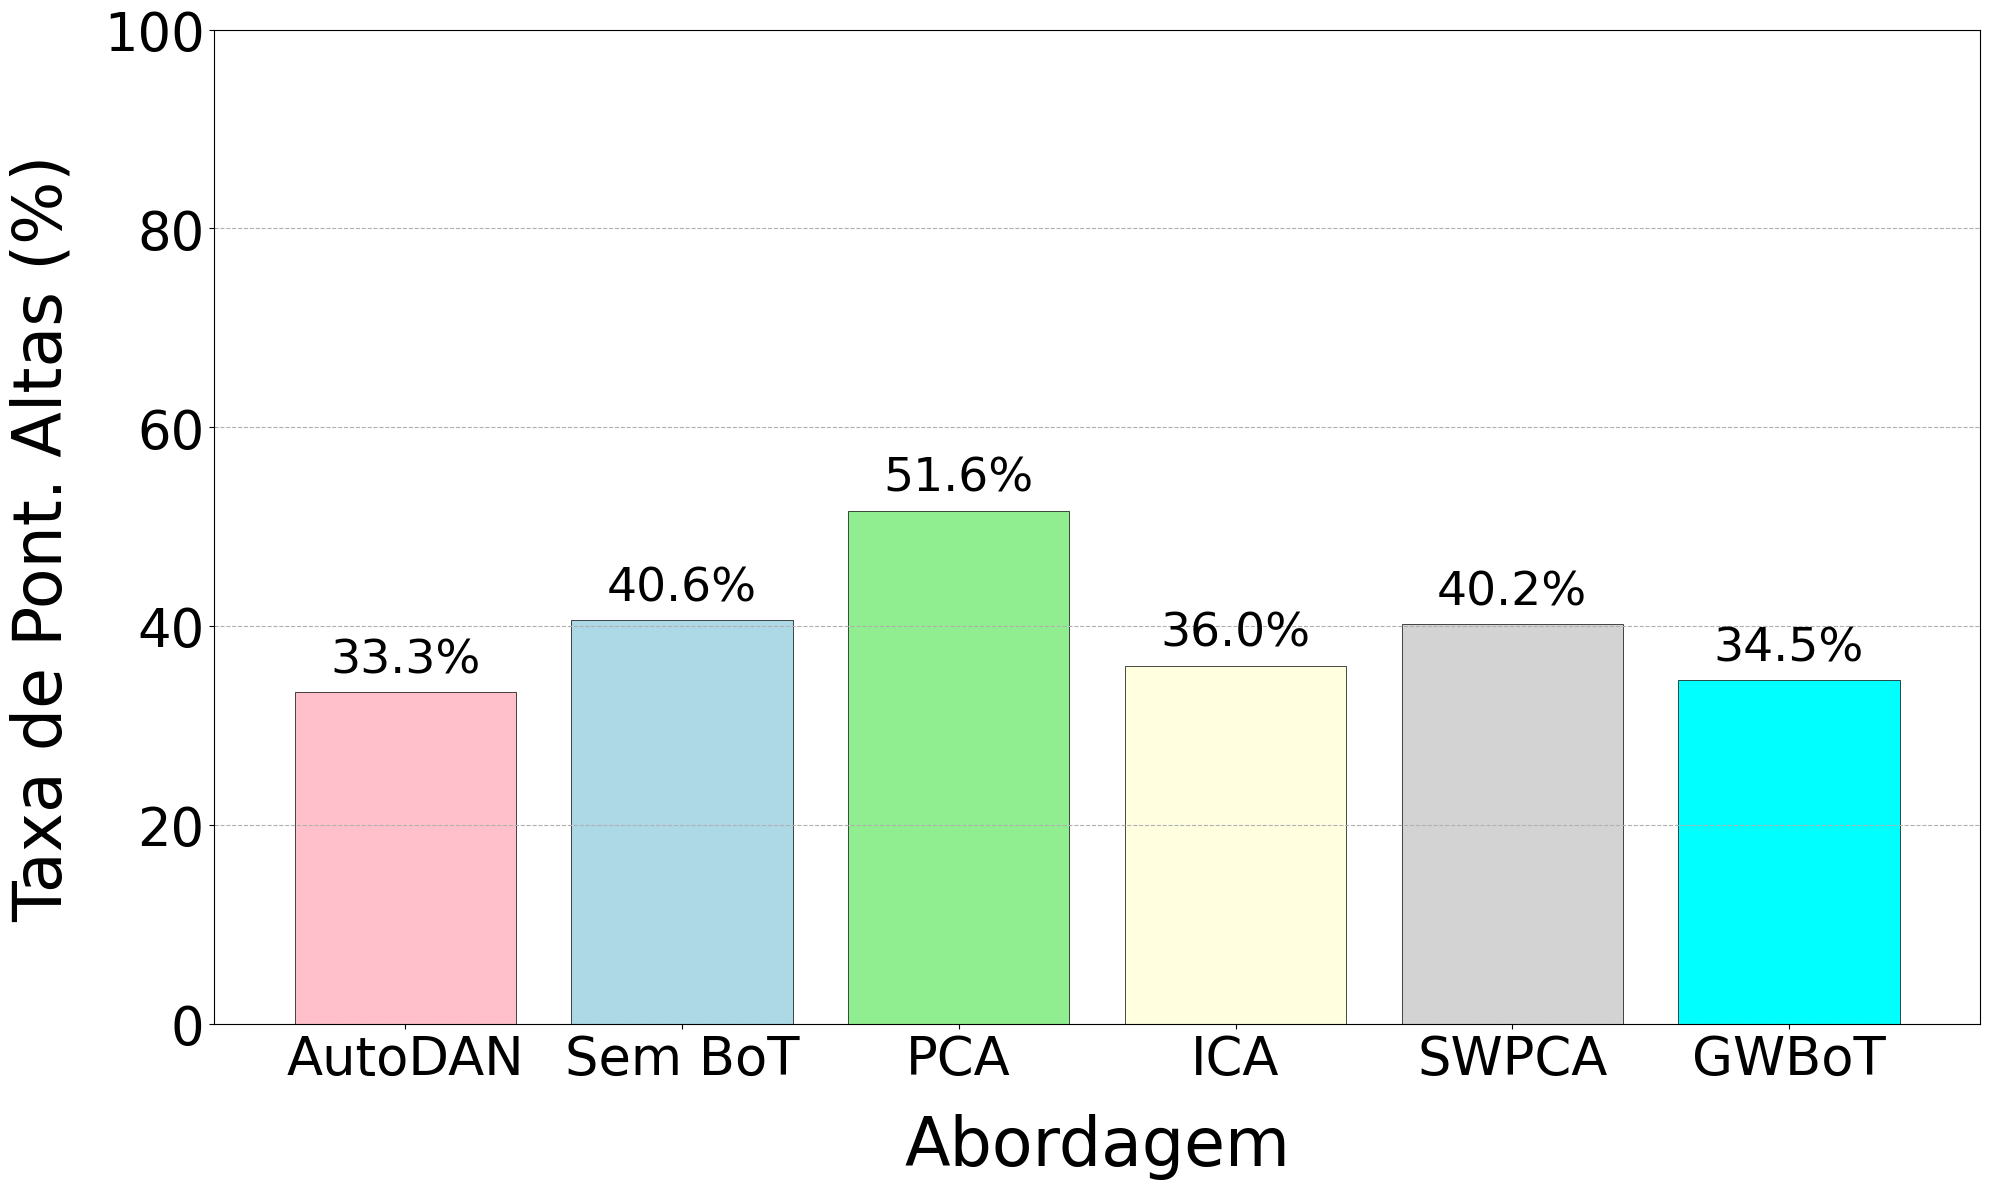

In [214]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os

# Create directory
os.makedirs('plots', exist_ok=True)

# 1. Load files
files = {
    'methods': 'final_results_without_metrics.json',
    'base': 'final_results_base_test.json',
    'adn': 'adn_attack_logs.json'
}

data = {}
for key, filename in files.items():
    try:
        with open(filename, 'r') as f:
            data[key] = json.load(f)
    except FileNotFoundError:
        print(f"Erro: Ficheiro {filename} não encontrado.")
        data[key] = None

# --- Process Scores ---
scores_map = {}

# 1. Methods (PCA, ICA, SWPCA, GWBoT)
if data['methods']:
    for approach, cases in data['methods'].items():
        all_scores = []
        for case_id, content in cases.items():
            if 'scores' in content:
                all_scores.extend(content['scores'])
        if all_scores:
            scores_map[approach] = all_scores

# 2. Baseline (will be mapped to 'Sem BoT')
if data['base']:
    base_scores = []
    for item in data['base']:
        if 'scores' in item:
            base_scores.extend(item['scores'])
        elif 'base_scores' in item:
            base_scores.extend(item['base_scores'])
    if base_scores:
        scores_map['Baseline'] = base_scores

# 3. ADN (will be mapped to 'AutoDAN')
if data['adn']:
    attacks = {}
    for item in data['adn']:
        aid = item.get('attack_id', 'unknown')
        s = 0
        
        # Extract score
        if 'score' in item:
             s = item['score']
        elif 'evaluation' in item and isinstance(item['evaluation'], dict) and 'score' in item['evaluation']:
             s = item['evaluation']['score']
        elif 'target_response' in item:
            match = re.search(r'Score:\s*\*\*?([\d\.]+)\*\*?', item['target_response'])
            if match:
                s = float(match.group(1))
        
        if aid not in attacks:
            attacks[aid] = []
        attacks[aid].append(s)
            
    # Max score per attack
    adn_scores = []
    for aid, s_list in attacks.items():
        if s_list:
            adn_scores.append(max(s_list))
    
    if adn_scores:
        scores_map['ADN'] = adn_scores

# --- Calculate Percentages and Map to Requested Order ---
# Requested Order: AutoDAN, Sem BoT, PCA, ICA, SWPCA, GWBoT
# Requested Colors: pink, lightblue, lightgreen, lightyellow, lightgrey, cyan

target_order = [
    {'key': 'ADN', 'label': 'AutoDAN', 'color': 'pink'},
    {'key': 'Baseline', 'label': 'Sem BoT', 'color': 'lightblue'},
    {'key': 'pca', 'label': 'PCA', 'color': 'lightgreen'},
    {'key': 'ica', 'label': 'ICA', 'color': 'lightyellow'},
    {'key': 'score_weighted_pca', 'label': 'SWPCA', 'color': 'lightgrey'},
    {'key': 'gradient_weighted', 'label': 'GWBoT', 'color': 'cyan'}
]

plot_data_labels = []
plot_data_values = []
plot_data_colors = []

for item in target_order:
    key = item['key']
    # Find the key in scores_map (handle potential key mismatches if necessary, though we control keys above)
    # The keys in scores_map are: 'pca', 'ica', 'score_weighted_pca', 'gradient_weighted', 'Baseline', 'ADN'
    # These match exactly what we put in.
    
    if key in scores_map:
        scores = scores_map[key]
        total = len(scores)
        if total > 0:
            count = sum(1 for s in scores if s >= 8.5)
            pct = (count / total) * 100
            
            plot_data_labels.append(item['label'])
            plot_data_values.append(pct)
            plot_data_colors.append(item['color'])
        else:
            # If data exists but empty?
            plot_data_labels.append(item['label'])
            plot_data_values.append(0.0)
            plot_data_colors.append(item['color'])
    else:
        # If key missing in data, skip or add 0?
        # Better to add 0 to maintain color mapping order if the user expects strict adherence
        print(f"Warning: Data for {key} not found.")
        plot_data_labels.append(item['label'])
        plot_data_values.append(0.0)
        plot_data_colors.append(item['color'])

# --- Plotting ---
plt.figure(figsize=(20, 12))

# Create bars
bars = plt.bar(plot_data_labels, plot_data_values, color=plot_data_colors, edgecolor='black', linewidth=0.5)

# Labels
plt.ylabel('Taxa de Pont. Altas (%) ', fontsize=48, labelpad=20)
plt.xlabel('Abordagem', fontsize=48, labelpad=20)

# Ticks
plt.xticks(fontsize=38)
plt.yticks(fontsize=38)

# Y-limit
plt.ylim(0, 100)

# Grid
plt.grid(axis='y', linestyle='--')

# Annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=34)


output_filename = 'plots/success_rate_comparison.pdf'
plt.tight_layout()
plt.savefig(output_filename)
plt.show()
